# Ejercicio práctico Clasificación problemas servidores

## Julián David Pérez Navarro - Data engineering bootcamp - Datapath

### Librerías

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

### Ruta del archivo de procesos

In [2]:
DATOS_PROCESOS_PATH = Path.cwd().parent / "data" / "datos_procesos.csv"

In [3]:
df = pd.read_csv(DATOS_PROCESOS_PATH, sep="|")

df.head()

,ID_Proceso,Uso_CPU,Uso_Memoria,Numero_Hilos,Tiempo_Ejecucion,Numero_Errores,Tipo_Proceso,Estado
0,1,37.454012,59.515562,16,8.184879,3,Aplicación,0
1,2,95.071431,36.471714,18,76.195256,8,Aplicación,0
2,3,73.199394,0.537562,21,46.991138,3,Aplicación,0
3,4,59.865848,56.108773,28,87.884325,4,Aplicación,0
4,5,15.601864,89.657041,39,4.622599,1,Sistema,0


Se usó el separador "|" ya que es el separador configurado en el sistema

Antes de continuar con el EDA, se eliminará la columna `ID_Proceso` ya que es una columna de ID y genera ruido para el análisis

In [4]:
df_procesos = df.drop(columns=["ID_Proceso"])

df_procesos.head()

,Uso_CPU,Uso_Memoria,Numero_Hilos,Tiempo_Ejecucion,Numero_Errores,Tipo_Proceso,Estado
0,37.454012,59.515562,16,8.184879,3,Aplicación,0
1,95.071431,36.471714,18,76.195256,8,Aplicación,0
2,73.199394,0.537562,21,46.991138,3,Aplicación,0
3,59.865848,56.108773,28,87.884325,4,Aplicación,0
4,15.601864,89.657041,39,4.622599,1,Sistema,0


Notamos que la información se carga sin problemas. Procederemos a realizar el EDA

### EDA

Miremos los tipos de datos del dataset, especialmente que todos coincidan

In [5]:
df_procesos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Uso_CPU           1000000 non-null  float64
 1   Uso_Memoria       1000000 non-null  float64
 2   Numero_Hilos      1000000 non-null  int64  
 3   Tiempo_Ejecucion  1000000 non-null  float64
 4   Numero_Errores    1000000 non-null  int64  
 5   Tipo_Proceso      1000000 non-null  object 
 6   Estado            1000000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 53.4+ MB


Miremos los valores faltantes en el dataset

In [6]:
missing_values = df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

Valores faltantes por columna:
 ID_Proceso          0
Uso_CPU             0
Uso_Memoria         0
Numero_Hilos        0
Tiempo_Ejecucion    0
Numero_Errores      0
Tipo_Proceso        0
Estado              0
dtype: int64


Se dividen en variables independientes (X) y variable dependiente (y)

In [7]:
X = df_procesos.drop(columns=["Estado"], axis=1)
y = df_procesos["Estado"]

Analicemos la distribución de las variables numéricas

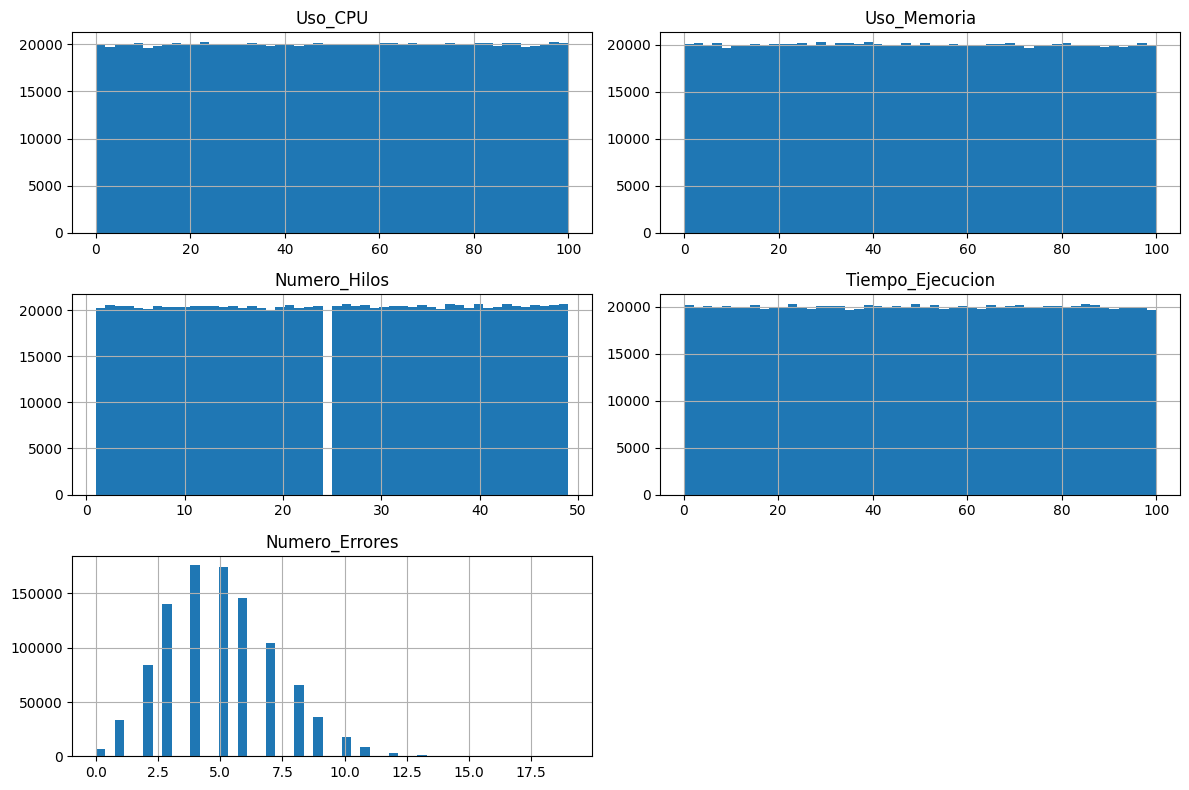

In [8]:
# Se analizarán aquellas variables cuyo tipo de dato sea numérico (float e int), y se graficará su distribución
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].hist(figsize=(12, 8), bins=50)
plt.tight_layout()
plt.show()

Ahora analicemos la frecuencia de las categorías de las variables categóricas

In [9]:
# Se tendrán en cuenta las variables tipo object
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nFrecuencia de categorías en '{col}':")
    print(df[col].value_counts())


Frecuencia de categorías en 'Tipo_Proceso':
Tipo_Proceso
Servicio      334085
Aplicación    332961
Sistema       332954
Name: count, dtype: int64


Al ser una variable categórica, se realizará un proceso posterior de "encoding" para convertirla en variable numérica

Ahora, miremos la distribución de la variable objetivo con el fin de identificar balanceo de clases

Distribución de la variable objetivo 'Estado':
Estado
0    0.935369
1    0.064631
Name: proportion, dtype: float64


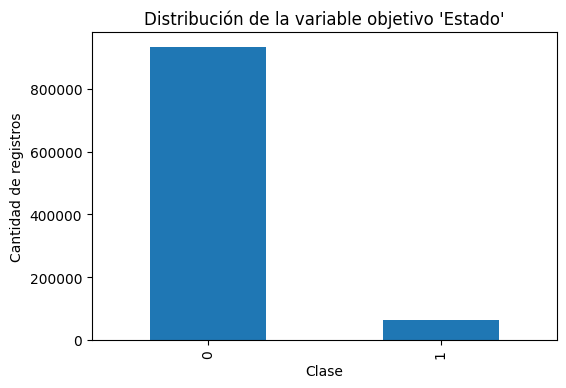

Existe desbalance entre las clases.


In [10]:
estado_counts = df['Estado'].value_counts(normalize=True)
print("Distribución de la variable objetivo 'Estado':")
print(estado_counts)

plt.figure(figsize=(6,4))
df['Estado'].value_counts().plot(kind='bar')
plt.title("Distribución de la variable objetivo 'Estado'")
plt.xlabel("Clase")
plt.ylabel("Cantidad de registros")
plt.show()

# Determinación de desbalance (se usará un umbral de 0.4 para considerar desbalance)
if estado_counts.min() < 0.4:
    print("Existe desbalance entre las clases.")
else:
    print("No existe un desbalance significativo entre las clases.")

Al existir un desbalance entre las clases, se usará el método de SMOTE para crear nuevas muestras de la clase minoritaria para no perder información existente de la clase mayoritaria

Miremos si existen valores duplicados en el dataset

In [11]:
# Verificar si existen filas duplicadas en el dataset
duplicados = X.duplicated().sum()
print(f"Número de filas duplicadas en el dataset: {duplicados}")

if duplicados > 0:
    print("Existen valores duplicados en el dataset.")
else:
    print("No existen valores duplicados en el dataset.")

Número de filas duplicadas en el dataset: 0
No existen valores duplicados en el dataset.


Procedemos a organizar el dataset en los 3 conjuntos (entrenamiento, validación y pruebas)

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=22, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=22, stratify=y_train)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

Tamaño del conjunto de entrenamiento: (700000, 6)
Tamaño del conjunto de validación: (350000, 6)
Tamaño del conjunto de prueba: (350000, 6)


Se realizará el one-hot encoding sobre la variable categórica

In [13]:
categorical_cols

Index(['Tipo_Proceso'], dtype='object')

In [14]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
ohe.fit(X_train[categorical_cols])

encoded_cols_train = pd.DataFrame(
    ohe.transform(X_train[categorical_cols]),
    columns=ohe.get_feature_names_out(),
    index=X_train.index)

encoded_cols_val = pd.DataFrame(
    ohe.transform(X_val[categorical_cols]),
    columns=ohe.get_feature_names_out(),
    index=X_val.index)

encoded_cols_test = pd.DataFrame(
    ohe.transform(X_test[categorical_cols]),
    columns=ohe.get_feature_names_out(),
    index=X_test.index)

X_train_encoded = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), encoded_cols_train.reset_index(drop=True)], axis=1)
X_val_encoded = pd.concat([X_val.drop(columns=categorical_cols).reset_index(drop=True), encoded_cols_val.reset_index(drop=True)], axis=1)
X_test_encoded = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), encoded_cols_test.reset_index(drop=True)], axis=1)

print("\nDataset de entrenamiento tras One-Hot Encoding:")
print(X_train_encoded.head())


Dataset de entrenamiento tras One-Hot Encoding:
     Uso_CPU  Uso_Memoria  Numero_Hilos  Tiempo_Ejecucion  Numero_Errores  \
0  29.249369    26.824178            25         58.476116               4   
1  93.269534     5.679184            48         39.239492               7   
2  82.760455    51.994644            20         41.727167               7   
3  43.577065    18.190243            48         31.600070               5   
4  93.163124    55.731909            14         24.877049               7   

   Tipo_Proceso_Aplicación  Tipo_Proceso_Servicio  Tipo_Proceso_Sistema  
0                      0.0                    1.0                   0.0  
1                      0.0                    0.0                   1.0  
2                      0.0                    1.0                   0.0  
3                      1.0                    0.0                   0.0  
4                      1.0                    0.0                   0.0  


Ahora se escalarán los datos con StandardScaler

In [15]:
numeric_cols

Index(['Uso_CPU', 'Uso_Memoria', 'Numero_Hilos', 'Tiempo_Ejecucion',
       'Numero_Errores'],
      dtype='object')

In [16]:
scaler = StandardScaler()
scaler.fit(X_train_encoded[numeric_cols])

X_train_processed = X_train_encoded.copy()
X_val_processed = X_val_encoded.copy()
X_test_processed = X_test_encoded.copy()

X_train_processed[numeric_cols] = scaler.transform(X_train_encoded[numeric_cols])
X_val_processed[numeric_cols] = scaler.transform(X_val_encoded[numeric_cols])
X_test_processed[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])

print("\nDataset de entrenamiento tras escalado:")
print(X_train_processed.head())


Dataset de entrenamiento tras escalado:
    Uso_CPU  Uso_Memoria  Numero_Hilos  Tiempo_Ejecucion  Numero_Errores  \
0 -0.718980    -0.800893     -0.002597          0.292675       -0.448802   
1  1.499431    -1.533825      1.622823         -0.374821        0.892198   
2  1.135273     0.071572     -0.355950         -0.288501        0.892198   
3 -0.222500    -1.100164      1.622823         -0.639904       -0.001802   
4  1.495744     0.201114     -0.779972         -0.873187        0.892198   

   Tipo_Proceso_Aplicación  Tipo_Proceso_Servicio  Tipo_Proceso_Sistema  
0                      0.0                    1.0                   0.0  
1                      0.0                    0.0                   1.0  
2                      0.0                    1.0                   0.0  
3                      1.0                    0.0                   0.0  
4                      1.0                    0.0                   0.0  


Realizaremos el SMOTE para balancear las clases en el conjunto de entrenamiento

In [17]:
print("Distribución de clases antes de aplicar SMOTE:")
print(y_train.value_counts(normalize=True))

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("\nDistribución de clases después de aplicar SMOTE:")
print(y_train_smote.value_counts(normalize=True))

Distribución de clases antes de aplicar SMOTE:
Estado
0    0.935369
1    0.064631
Name: proportion, dtype: float64

Distribución de clases después de aplicar SMOTE:
Estado
0    0.5
1    0.5
Name: proportion, dtype: float64


### Modelado

Usaremos el modelo de regresión logística

In [18]:
param_grid_lr = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

model_lr = LogisticRegression(random_state=42, max_iter=1000)

# 2. Configurar y ejecutar GridSearchCV
# Usamos 'roc_auc' como métrica de puntuación para optimizar
grid_lr = GridSearchCV(model_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_smote, y_train_smote)

# 3. Obtener el mejor modelo
best_lr = grid_lr.best_estimator_
print(f"Mejores parámetros para Regresión Logística: {grid_lr.best_params_}")

Mejores parámetros para Regresión Logística: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


Accuracy: 0.90088
Precision: 0.3885431478643054
Recall: 0.9301091905751293
F1 Score: 0.5481165008075861
ROC AUC: 0.9712873652118974


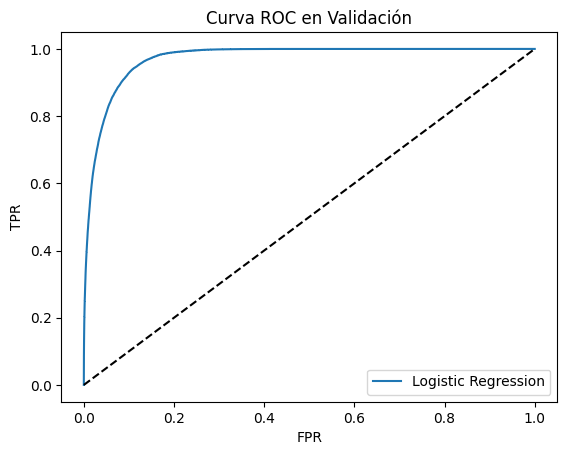

In [19]:
y_pred_lr = best_lr.predict(X_val_processed)
y_proba_lr = best_lr.predict_proba(X_val_processed)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Precision:", precision_score(y_val, y_pred_lr))
print("Recall:", recall_score(y_val, y_pred_lr))
print("F1 Score:", f1_score(y_val, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_val, y_proba_lr))

fpr_lr, tpr_lr, _ = roc_curve(y_val, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC en Validación')
plt.legend()
plt.show()

Árbol de decisión

In [20]:
param_grid_dt = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'criterion': ['entropy']
}

model_dt = DecisionTreeClassifier(random_state=42)

# 2. Configurar y ejecutar GridSearchCV
grid_dt = GridSearchCV(model_dt, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)
grid_dt.fit(X_train_smote, y_train_smote)

# 3. Obtener el mejor modelo
best_dt = grid_dt.best_estimator_
print(f"Mejores parámetros para Árbol de Decisión: {grid_dt.best_params_}")

Mejores parámetros para Árbol de Decisión: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}


Accuracy: 0.8905857142857143
Precision: 0.36608454940022556
Recall: 0.9470845674373369
F1 Score: 0.5280554083531543
ROC AUC: 0.9710403443046809


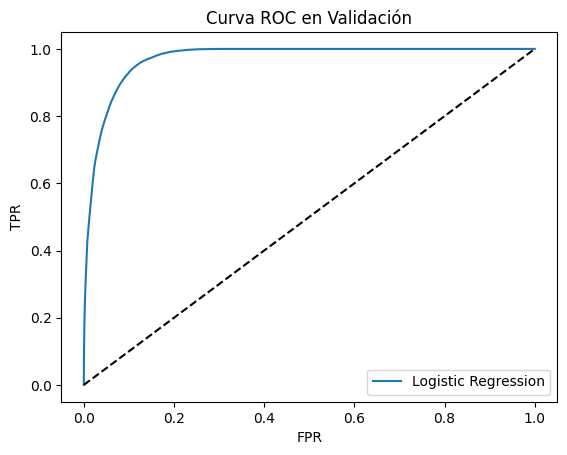

In [21]:
y_pred_dt = best_dt.predict(X_val_processed)
y_proba_dt = best_dt.predict_proba(X_val_processed)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred_dt))
print("Precision:", precision_score(y_val, y_pred_dt))
print("Recall:", recall_score(y_val, y_pred_dt))
print("F1 Score:", f1_score(y_val, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_val, y_proba_dt))

fpr_dt, tpr_dt, _ = roc_curve(y_val, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label="Logistic Regression")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC en Validación')
plt.legend()
plt.show()

Random Forest

In [22]:
param_grid_rf = {
    'n_estimators': [100, 200],      # Número de árboles en el bosque
    'max_depth': [10, 20],         # Profundidad máxima
    'min_samples_leaf': [1, 2]    # Mínimo de muestras en un nodo hoja
}

model_rf = RandomForestClassifier(random_state=42)

# 2. Configurar y ejecutar GridSearchCV
grid_rf = GridSearchCV(model_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

# 3. Obtener el mejor modelo
best_rf = grid_dt.best_estimator_
print(f"Mejores parámetros para Árbol de Decisión: {grid_rf.best_params_}")

KeyboardInterrupt: 

In [ ]:
y_pred_rf = best_rf.predict(X_val_processed)
y_proba_rf = best_rf.predict_proba(X_val_processed)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Precision:", precision_score(y_val, y_pred_rf))
print("Recall:", recall_score(y_val, y_pred_rf))
print("F1 Score:", f1_score(y_val, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_proba_rf))

fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC en Validación')
plt.legend()
plt.show()

Support Vector Machine (SVM)

In [ ]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

model_svm = SVC(random_state=42, probability=True)

# 2. Configurar y ejecutar GridSearchCV
# Habilitar `probability=True` es crucial para poder obtener la curva ROC
grid_svm = GridSearchCV(model_svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_svm.fit(X_train_smote, y_train_smote)

# 3. Obtener el mejor modelo
best_svm = grid_svm.best_estimator_
print(f"Mejores parámetros para SVM: {grid_svm.best_params_}")

In [ ]:
y_pred_svm = best_svm.predict(X_val_processed)
y_proba_svm = best_svm.predict_proba(X_val_processed)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("Precision:", precision_score(y_val, y_pred_svm))
print("Recall:", recall_score(y_val, y_pred_svm))
print("F1 Score:", f1_score(y_val, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_val, y_proba_svm))

fpr_svm, tpr_svm, _ = roc_curve(y_val, y_proba_svm)
plt.plot(fpr_svm, tpr_svm, label="Support Vector Machine")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC en Validación')
plt.legend()
plt.show()

Análisis final

In [ ]:
y_pred_lr = best_lr.predict(X_test_processed)
y_prob_lr = best_lr.predict_proba(X_test_processed)[:, 1]

y_pred_dt = best_dt.predict(X_test_processed)
y_prob_dt = best_dt.predict_proba(X_test_processed)[:, 1]

y_pred_rf = best_rf.predict(X_test_processed)
y_prob_rf = best_rf.predict_proba(X_test_processed)[:, 1]

y_pred_svm = best_svm.predict(X_test_processed)
y_prob_svm = best_svm.predict_proba(X_test_processed)[:, 1]

print("\n--- Evaluación Final: Regresión Logística ---")
print(classification_report(y_test, y_pred_lr))
print(f"AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")

print("\n--- Evaluación Final: Árbol de Decisión ---")
print(classification_report(y_test, y_pred_dt))
print(f"AUC Score: {roc_auc_score(y_test, y_prob_dt):.4f}")

print("\n--- Evaluación Final: Random Forest ---")
print(classification_report(y_test, y_pred_rf))
print(f"AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")

print("\n--- Evaluación Final: Support Vector Machine ---")
print(classification_report(y_test, y_pred_svm))
print(f"AUC Score: {roc_auc_score(y_test, y_prob_svm):.4f}")